We have our algorithm to generate the data. 

In [38]:
true_params = {'f': 0.1, 'lam': 0.5, 'mu': 5.28, 'sigma': 0.018}

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL, BinnedNLL
from scipy.stats import norm, expon
from time import process_time

# import function to generate data
from generation import generate_from_total_pdf

# generate 100000 events
N_events= 100000
dataset = generate_from_total_pdf(N_events, f=0.1, lam=0.5, mu=5.28, sigma=0.018, alpha=5, beta=5.6)


Generated 100000 events in 0.004458s


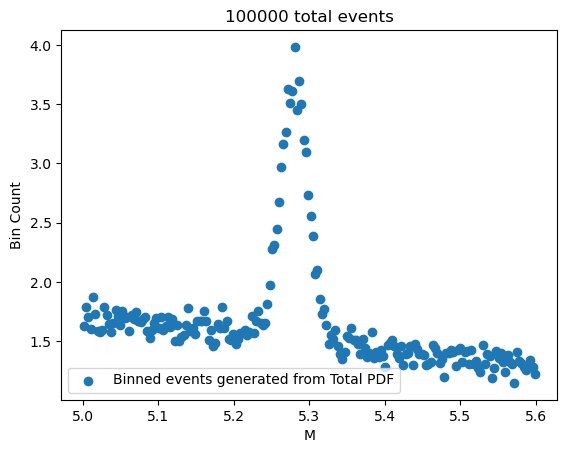

In [33]:
# Bin the events
bins = 200
bin_counts, bin_edges = np.histogram(dataset, bins=bins, density=True)

# Calculate bin midpoints
midpoints = 0.5 * (bin_edges[:-1] + bin_edges[1:])

fig, ax = plt.subplots()

# Plotting bin count vs midpoints
ax.scatter(midpoints, bin_counts, label='Binned events generated from Total PDF', marker='o')

ax.set_xlabel('M')
ax.set_ylabel('Bin Count')
ax.set_title(f'{N_events} total events')

ax.legend()

In [34]:
###############################################
# The models imported from pdfs.py were causing errors
# I redefine the total_pdf as a temporary solution
# GOTTA GO BACK AND CHANGE THIS
###############################################

def model(M, f, lam, mu, sigma):
    alpha = 5
    beta = 5.6

    # signal normalisation factor
    A = 1/(norm.cdf(x=beta, loc=mu, scale=sigma) - norm.cdf(x=alpha, loc=mu, scale=sigma))

    # background normalisation factor
    B = 1/(expon.cdf(x=beta, scale=1/lam) - expon.cdf(x=alpha, scale=1/lam))

    signal = A*norm.pdf(x=M, loc=mu, scale=sigma)
    background = B*expon.pdf(x=M, scale=1/lam)

    return f*signal + (1-f)*background

In [35]:
# (unbinned) negative log likelihood as the cost function
unbinned_nll = UnbinnedNLL(dataset , model)

# Minimisation object
# Passing random starting values for the parameters
alpha, beta = 5, 5.6
mi = Minuit(
    fcn = unbinned_nll,
    f = 0.1,
    lam = 0.5,
    mu = 5.28,
    sigma = 0.018,
)

# Minimise the cost function
mi.migrad()

# Hesse algorithm
mi.hesse()

# print the fit result
print(mi)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.097e+05                 │              Nfcn = 107              │
│ EDM = 1.65e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─────

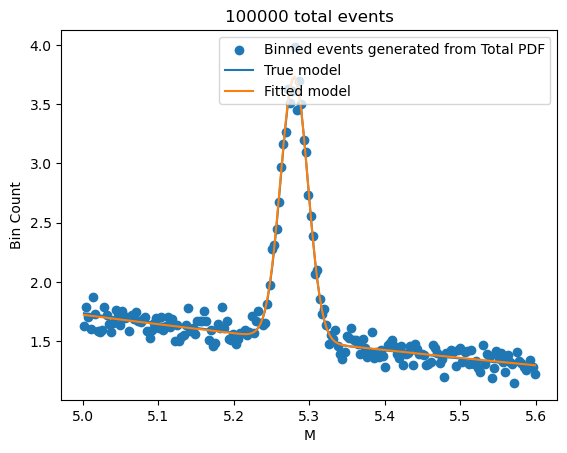

In [40]:
fig, ax = plt.subplots()

# Plotting bin count vs midpoints
ax.scatter(midpoints, bin_counts, label='Binned events generated from Total PDF', marker='o')
ax.plot(midpoints, model(midpoints, **true_params), label='True model')
ax.plot(midpoints, model(midpoints, *mi.values), label='Fitted model')

ax.set_xlabel('M')
ax.set_ylabel('Bin Count')
ax.set_title(f'{N_events} total events')

ax.legend()

The cdf of the total PDF is given by the function defined below. In the report I will definitely have to justify this:

In [22]:
def total_cdf(M, f, lam, mu, sigma):
    alpha = 5
    beta = 5.6

    A = 1/(norm.cdf(x=beta, loc=mu, scale=sigma) - norm.cdf(x=alpha, loc=mu, scale=sigma))

    B = 1/(expon.cdf(x=beta, scale=1/lam) - expon.cdf(x=alpha, scale=1/lam))

    signal_cdf = A*(norm.cdf(x=M, loc=mu, scale=sigma) - norm.cdf(x=alpha, loc=mu, scale=sigma))
    background_cdf = B*(expon.cdf(x=M, scale=1/lam) - expon.cdf(x=alpha, scale=1/lam))

    return f*signal_cdf + (1-f)*background_cdf

In [28]:
binned_nll = BinnedNLL(bin_counts, bin_edges, total_cdf)
binned_mi = Minuit(
    fcn = binned_nll,
    f = 0.1,
    lam = 0.5,
    mu = 5.28,
    sigma = 0.018,
)

start = process_time()
binned_mi.migrad()
binned_mi.hesse()
stop = process_time()

print ( " ++++ BINNED ++++ " )
print ( binned_mi.params )
print ( f" Took { stop - start :5.3} seconds ")

 ++++ BINNED ++++ 
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ f     │  0.1026   │  0.0017   │            │            │         │         │       │
│ 1 │ lam   │   0.560   │   0.019   │            │            │         │         │       │
│ 2 │ mu    │  5.28016  │  0.00033  │            │            │         │         │       │
│ 3 │ sigma │ 18.22e-3  │  0.33e-3  │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
 Took 0.0311 seconds 


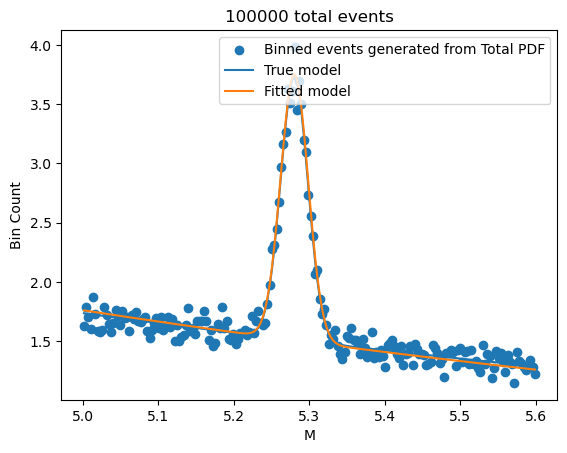

In [41]:
fig, ax = plt.subplots()

# Plotting bin count vs midpoints
ax.scatter(midpoints, bin_counts, label='Binned events generated from Total PDF', marker='o')
ax.plot(midpoints, model(midpoints, **true_params), label='True model')
ax.plot(midpoints, model(midpoints, *binned_mi.values), label='Fitted model')

ax.set_xlabel('M')
ax.set_ylabel('Bin Count')
ax.set_title(f'{N_events} total events')

ax.legend()